In [18]:
import os
import glob
import json
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_preprocessing as ART_pre

In [2]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_in = os.path.join(dir_base,'Satellite','IMERG','1dy','IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')
DATA = xr.open_dataset(dir_in)
lat = DATA['lat'].values
lon = DATA['lon'].values
lon_IMERG, lat_IMERG = np.meshgrid(lon,lat)
time_IMERG = pd.to_datetime(DATA.time.values)

DATA

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 8674, lat: 121, lon: 131)
Coordinates:
  * time     (time) datetime64[ns] 69kB 2000-06-01 2000-06-02 ... 2024-02-29
  * lat      (lat) float64 968B 35.95 36.05 36.15 36.25 ... 47.75 47.85 47.95
  * lon      (lon) float32 524B 5.95 6.05 6.15 6.25 ... 18.65 18.75 18.85 18.95
Data variables:
    PRE      (time, lat, lon) float64 1GB ...
Attributes:
    description:  IMERG daily data for Italy region

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

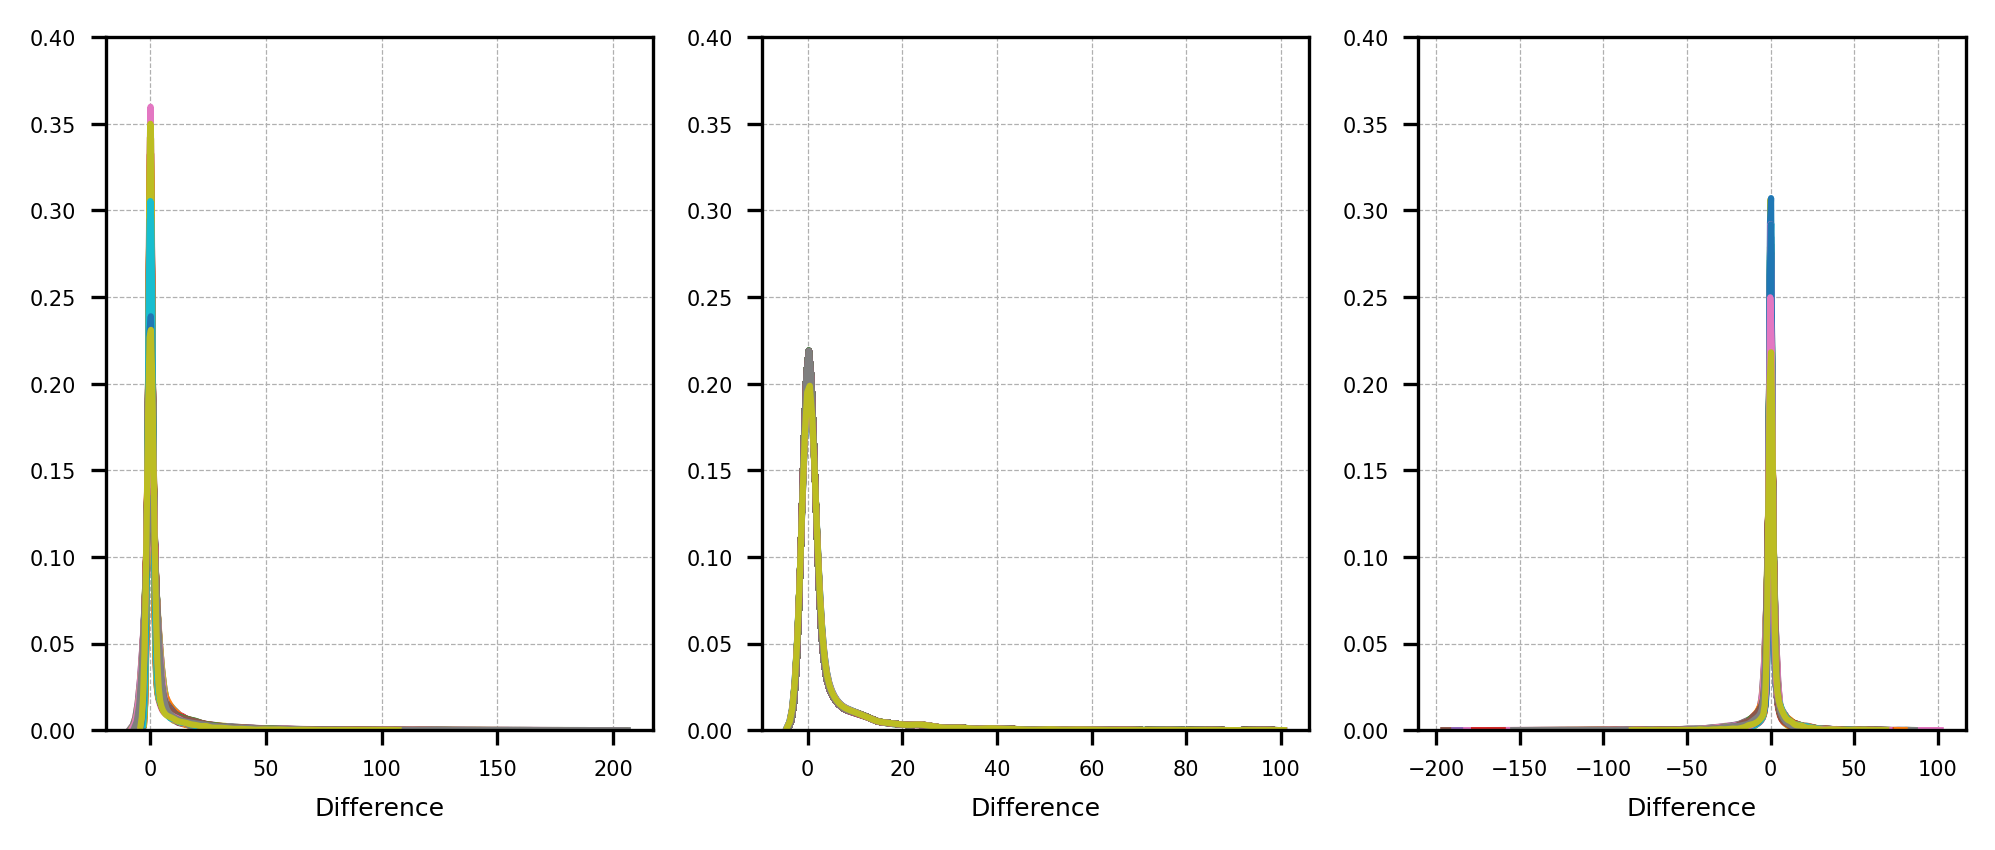

In [86]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

for nn in range(len(wa_pd)):
    filename = os.path.join(OBS_base,'Veneto','BACKUP_RAW','CLEAR_1dy',f'{wa_pd.iloc[nn].File_Name}.csv')
    lat_ref = wa_pd.iloc[nn].Lat
    lon_ref = wa_pd.iloc[nn].Lon 
    df_OBS = pd.read_csv(filename, sep=',')
    df_OBS['TIME'] = pd.to_datetime(df_OBS['TIME'])
    df_OBS = df_OBS.dropna()
    df_OBS = df_OBS[['TIME', 'PRE']].rename(columns={'PRE': 'PRE_OBS'})
    df_OBS.loc[df_OBS['PRE_OBS'] > 200, 'PRE_OBS'] = np.nan
    # print(f'5 Max: {np.sort(df_OBS['PRE_OBS'].values)[-5:]}')
    
    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_ref, lon_ref)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    # print(min_index)

    lat_close = DATA.PRE[:, min_index[0], min_index[1]].lat.values
    lon_close = DATA.PRE[:, min_index[0], min_index[1]].lon.values
    
    df_IMERG = pd.DataFrame({'TIME': time_IMERG, 'PRE_IMERG': DATA.PRE[:, 100, 66].values})
    
    df_final = df_OBS.merge(df_IMERG, on='TIME', how='inner')
    df_final['ERROR'] = (df_final['PRE_IMERG'] - df_final['PRE_OBS'])
    
    ax1 = plt.subplot(gs[0, 0])
    sns.kdeplot(df_final['PRE_OBS'],cumulative=False,fill=False,ax=ax1,multiple="stack",label=f'OBS')
    ax1.tick_params(axis='both', which='major', labelsize=5)
    ax1.set_xlabel('Difference', fontsize=6)
    ax1.set_ylabel('', fontsize=6)
    ax1.set_ylim(0,0.4)
    ax1.grid(linestyle='--',linewidth=0.3)
    
    ax1 = plt.subplot(gs[0, 1])
    sns.kdeplot(df_final['PRE_IMERG'],cumulative=False,fill=False,ax=ax1,multiple="stack",label=f'IMERG')
    ax1.tick_params(axis='both', which='major', labelsize=5)
    ax1.set_xlabel('Difference', fontsize=6)
    ax1.set_ylabel('', fontsize=6)
    ax1.set_ylim(0,0.4)
    ax1.grid(linestyle='--',linewidth=0.3)
    
    ax1 = plt.subplot(gs[0, 2])
    sns.kdeplot(df_final['ERROR'],cumulative=False,fill=False,ax=ax1,multiple="stack",label=f'DIFF')
    ax1.tick_params(axis='both', which='major', labelsize=5)
    ax1.set_xlabel('Difference', fontsize=6)
    ax1.set_ylabel('', fontsize=6)
    ax1.set_ylim(0,0.4)
    ax1.grid(linestyle='--',linewidth=0.3)

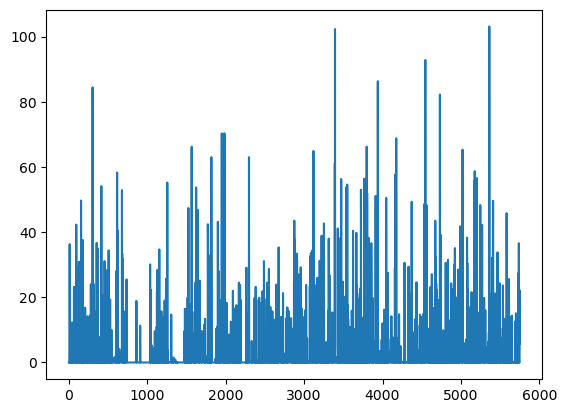

In [69]:
plt.plot(df_final['PRE_OBS'])

<Axes: xlabel='ERROR', ylabel='Density'>

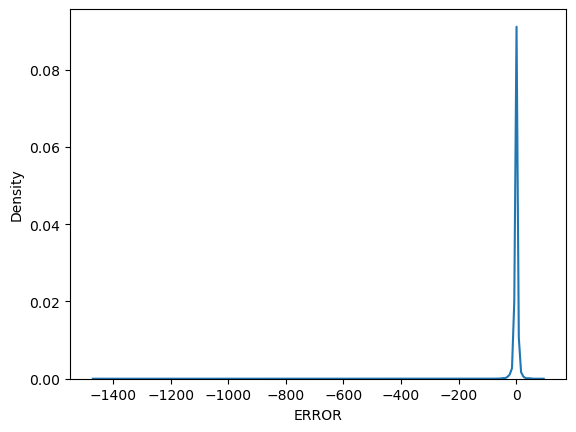

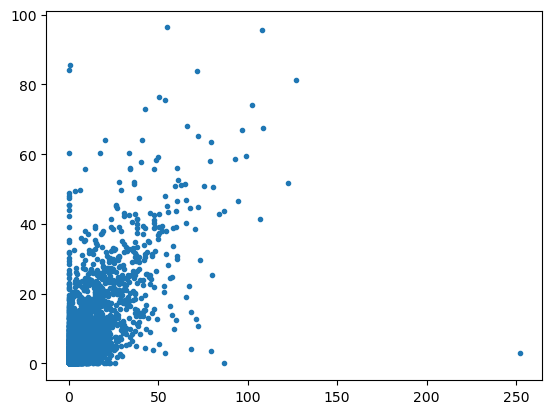

In [51]:
plt.plot(df_final['PRE_OBS'],df_final['PRE_IMERG'],'.')